# Contents

In this notebook, I extend the phase error sequence presented in Lucero09. We extend this method to the qutrit case.

In [1]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [2]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [3]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 109
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


In [4]:
amp_sx12 = 0.08286756603683343
amp_x12 = amp_sx12*2
dur_12 = 120
dur = 120

# beta_sx12 = -0.44994878857958076

In [5]:
def schedule_builder(params, name, frequency=rough_12_freq):
    """
        Build a schedule for pulse on 12
    """

    num_pulse = params['num_pulse']

    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(frequency, drive_chan)
        for n in range(num_pulse):
            with qiskit.pulse.phase_offset(params['angle'][n], drive_chan):
                qiskit.pulse.play(qiskit.pulse.Drag(duration=params['dur'][n],
                                                    amp=params['amp'][n], 
                                                    sigma=int(params['dur'][n]/4), 
                                                    beta=params['beta'][n],
                                                    name=name), drive_chan)
    return schedule
    
def gate(name, weight):
    return qiskit.circuit.Gate(name, weight, [])

In [6]:
def init_quantum_circuit():

    gc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    gc.measure(qubit, cbit)

    fc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    fc.measure(qubit, cbit)

    p12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_x12], 'beta': [0]}
    p12_sched = schedule_builder(p12_params, r'$X^{12}(\pi)$')
    p12_gate = gate(r'$X^{12}$', weight)

    sc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    sc.x(qubit)
    sc.append(p12_gate, [qubit])
    sc.x(qubit)
    sc.measure(qubit, cbit)
    sc.add_calibration(p12_gate, [qubit], p12_sched)

    return [gc, fc, sc]

# Main APE circuit

In [7]:
qc_pe_list = init_quantum_circuit()

optimized_beta = 0

reps = [1, 3, 5, 7, 9]
angle_swept = np.linspace(-np.pi/6, -np.pi/6 + 2 * np.pi, 100)

sx12_gate = gate('SX12', weight)
sx12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_sx12], 'beta': [optimized_beta]}
sx12_sched = schedule_builder(sx12_params, r'$R^{12}(\pi/2)$')

pseudo_gate = gate('Pseudo Identity', weight)
pseudo_params = {'num_pulse': 2, 'angle': [0, 0], 'dur': [dur, dur], 'amp': [amp_sx12, -amp_sx12], 'beta': [optimized_beta, optimized_beta]}
pseudo_sched = schedule_builder(pseudo_params, r'$I$')

for rep in reps:
    for angle in angle_swept:
        """
            Amplified phase error sequence circuit
        """
        asx12_gate = gate('ASX12', weight)
        asx12_params = {'num_pulse': 1, 'angle': [angle], 'dur': [dur], 'amp': [-amp_sx12], 'beta': [optimized_beta]}
        asx12_sched = schedule_builder(asx12_params, r'$R_{\phi}^{12}(\pi/2)$')

        ape_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
        ape_circ.x(qubit)
        ape_circ.append(sx12_gate, [qubit])
        for j in range(rep):
            ape_circ.append(pseudo_gate, [qubit])
        ape_circ.append(asx12_gate, [qubit])
        ape_circ.x(qubit)
        ape_circ.measure(qubit, cbit)

        ape_circ.add_calibration(sx12_gate, [qubit], sx12_sched)
        ape_circ.add_calibration(pseudo_gate, [qubit], pseudo_sched)
        ape_circ.add_calibration(asx12_gate, [qubit], asx12_sched)
        qc_pe_list.append(ape_circ)

pe_shots = int(2**11)

In [54]:
pe_job = backend.run(qc_pe_list, meas_level=1, meas_return='single', shots=pe_shots)
pe_job.job_id()

'ctnnswqx7b5g0080j48g'

In [62]:
pe_job = provider.backend.retrieve_job('ctnnswqx7b5g0080j48g')
pe_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [8]:
iqdata_retrieved = True
job_id = 'ctnnswqx7b5g0080j48g'

if iqdata_retrieved == False:
    pe_job = provider.backend.retrieve_job(job_id)
    pe_exp = ut.DataAnalysis(experiment=pe_job, average=False, shots=pe_shots, qubit=0)
    pe_exp.retrieve_data(average=False)
    with open('./calibrator/phase_error/qubit109/data/mapping/rep_13579_dur_120.pkl', 'wb') as f:
        pickle.dump(pe_exp.IQ_data, f)

else:
    pe_exp = ut.DataAnalysis(experiment=None, average=False, shots=pe_shots, qubit=0)
    pe_exp.IQ_data = np.load("./calibrator/phase_error/qubit109/data/mapping/rep_13579_dur_120_modified_discrim.pkl", allow_pickle=True)
    pe_exp.IQ_discrim = [pe_exp.IQ_data[1], pe_exp.IQ_data[2]]

pe_exp.build_discrim(num_states=2)
pe_exp.count_pop(num_states=2)
pe_exp.error_mitiq(num_states=2)

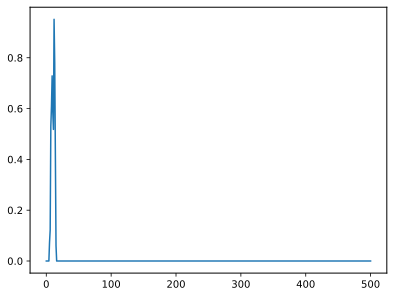

In [20]:
plt.plot(pe_exp.mitiq_data[:, 1])

In [16]:
population_reshaped = np.reshape(pe_exp.mitiq_data, (len(reps), len(angle_swept), 2))

ValueError: cannot reshape array of size 1002 into shape (5,100,2)

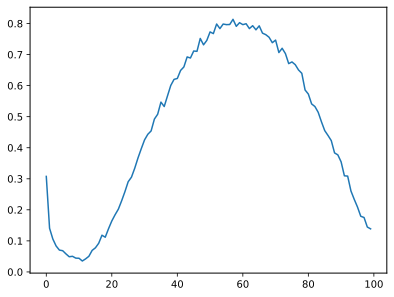

In [13]:
plt.plot(population_reshaped[0][:, 1])

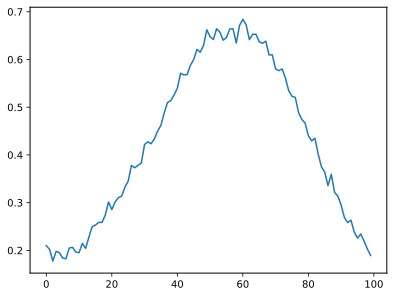

In [188]:
plt.plot(population_reshaped[4][:, 2]+population_reshaped[4][:, 1])

In [165]:
population_reshaped[0][:,2]

array([[7.33830081e-01, 5.31878906e-03, 2.60851130e-01],
       [9.16551869e-01, 8.69182804e-03, 7.47563026e-02],
       [9.75023216e-01, 4.00956038e-04, 2.45758280e-02],
       [9.98268422e-01, 0.00000000e+00, 1.73157759e-03],
       [1.00000000e+00, 3.46944695e-16, 0.00000000e+00],
       [1.00000000e+00, 2.22044605e-16, 2.91433544e-16],
       [1.00000000e+00, 0.00000000e+00, 2.77555756e-16],
       [1.00000000e+00, 5.55111512e-17, 0.00000000e+00],
       [1.00000000e+00, 5.55111512e-17, 0.00000000e+00],
       [1.00000000e+00, 5.55111512e-17, 5.55111512e-17],
       [1.00000000e+00, 0.00000000e+00, 4.99600361e-16],
       [1.00000000e+00, 1.52655666e-16, 0.00000000e+00],
       [1.00000000e+00, 2.77555756e-16, 0.00000000e+00],
       [1.00000000e+00, 1.38777878e-16, 0.00000000e+00],
       [1.00000000e+00, 1.11022302e-16, 0.00000000e+00],
       [1.00000000e+00, 1.11022302e-16, 1.94289029e-16],
       [9.77253353e-01, 8.98042536e-03, 1.37662217e-02],
       [9.71127753e-01, 2.15255

In [161]:
np.add(population_reshaped[0][], population_reshaped[0][:,1], population_reshaped[0][:,0])

array([2.66169919e-01, 8.34481307e-02, 2.49767841e-02, 1.73157759e-03,
       3.46944695e-16, 5.13478149e-16, 2.77555756e-16, 5.55111512e-17,
       5.55111512e-17, 1.11022302e-16, 4.99600361e-16, 1.52655666e-16,
       2.77555756e-16, 1.38777878e-16, 1.11022302e-16, 3.05311332e-16,
       2.27466471e-02, 2.88722475e-02, 3.73769068e-02, 6.93145967e-02,
       8.23778875e-02, 1.06225548e-01, 1.47387948e-01, 1.53843834e-01,
       1.89413287e-01, 2.10788090e-01, 2.51283589e-01, 2.76369035e-01,
       3.19877383e-01, 3.26974782e-01, 3.86056099e-01, 3.75894658e-01,
       4.34045311e-01, 4.66365674e-01, 4.73919295e-01, 4.84727477e-01,
       5.32975537e-01, 5.43838656e-01, 5.62868218e-01, 5.70326900e-01,
       5.96756404e-01, 6.30062210e-01, 6.43662921e-01, 6.47096874e-01,
       6.75126441e-01, 7.02277079e-01, 7.06982588e-01, 7.21169257e-01,
       7.26700609e-01, 7.50515325e-01, 7.30361981e-01, 7.74296057e-01,
       7.61861349e-01, 7.55954173e-01, 7.75420671e-01, 7.70003761e-01,
      

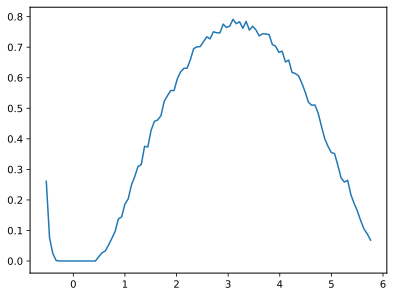

In [156]:
plt.plot(phase_sweep, population_reshaped[0][:, 2]+population_reshaped[0][:, 2])

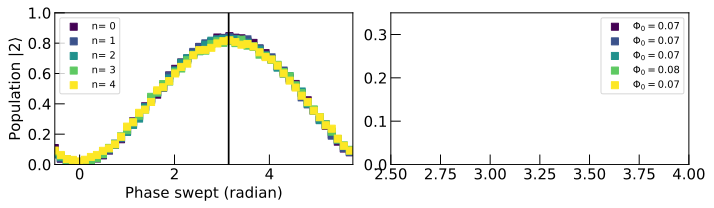

In [88]:
cmap = plt.cm.viridis
gradient_colors = np.linspace(0, 1, 5)

phase_sweep = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)

population2_ape_withY = []
ape_params_withY = []
ape_fits_withY = []
initial_phases_withY = []

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

for j in range(len(reps)):
    color = cmap(gradient_colors[j])
    population2_ape_withY.append(pop2_exp_raw[j])
    param, fit, pcov = ut.fit_function(phase_sweep, population2_ape_withY[j], 
                                      lambda x, A, B, omega, phi: (A*np.cos(omega*x+phi)+B),
                                      [0.5, 0.5, 1, 0])
    ape_params_withY.append(param)
    ape_fits_withY.append(fit)
    initial_phases_withY.append(param[3])
    ax1.scatter(phase_sweep[::2], population2_ape_withY[j][::2], marker='s', s=50, label=r'n= '+f'{j}', color=color)
    ax2.scatter(phase_sweep[::2], population2_ape_withY[j][::2], marker='s', s=50, label=r'$\Phi_0=$'+f'{round(param[3],2)}', color=color)
    # ax1.plot(phase_sweep, ape_fits_withY[j], linewidth=5.0, color=color)
    ax2.plot(phase_sweep, ape_fits_withY[j], linewidth=5.0, color=color)
    

ax1.set_xlim([min(phase_sweep), max(phase_sweep)])
ax1.set_ylim([0, 1])
ax2.set_xlim([2.5, 4])
ax2.set_ylim([0, 0.35])
ax1.axvline(3.1415926535897932, color='black', linewidth=1.75)
ax1.set_xlabel('Phase swept (radian)', size=15)
ax1.set_ylabel(r'Population $|2\rangle$', size=15)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=1.0)
    ax.tick_params(axis='both', which='minor', length=7, width=1.0)
    ax.legend()
    
fig.tight_layout()
# plt.savefig('./phase1/data/logical/step2_calibrating_halfpi_pulse/1_ape_halfpi_Y_correction.png', dpi=300)

# Main APE+DRAG circ

In [22]:
ad_circ_list = init_quantum_circuit()

reps = [7, 9, 11, 13, 15]
beta_swept = np.linspace(-2.5, 0.5, 100)

for rep in reps:
    for beta in beta_swept:
        """
            Amplified phase error sequence circuit
        """

        sx12_gate = gate('SX12', weight)
        sx12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_sx12], 'beta': [beta]}
        sx12_sched = schedule_builder(sx12_params, r'$R^{12}(\pi/2)$')
        
        pseudo_gate = gate('Pseudo Identity', weight)
        pseudo_params = {'num_pulse': 2, 'angle': [0, 0], 'dur': [dur, dur], 'amp': [amp_sx12, -amp_sx12], 'beta': [beta, beta]}
        pseudo_sched = schedule_builder(pseudo_params, r'$I$')

        msx12_gate = gate('ASX12', weight)
        msx12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [-amp_sx12], 'beta': [beta]}
        msx12_sched = schedule_builder(msx12_params, r'$R_{\phi}^{12}(\pi/2)$')

        ad_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
        ad_circ.x(qubit)
        ad_circ.append(sx12_gate, [qubit])
        for j in range(rep):
            ad_circ.append(pseudo_gate, [qubit])
        ad_circ.append(msx12_gate, [qubit])
        ad_circ.measure(qubit, cbit)

        ad_circ.add_calibration(sx12_gate, [qubit], sx12_sched)
        ad_circ.add_calibration(pseudo_gate, [qubit], pseudo_sched)
        ad_circ.add_calibration(msx12_gate, [qubit], msx12_sched)

        ad_circ_list.append(ad_circ)

ad_shots = int(2**11)

In [67]:
ad_job = backend.run(ad_circ_list, meas_level=1, meas_return='single', shots=ad_shots)
ad_job.job_id()

'ctbp4wvp16s0008nvq50'

In [69]:
ad_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [20]:
iqdata_retrieved = True
job_id = 'ctbp4wvp16s0008nvq50'

if iqdata_retrieved == False:
    ape_drag_job = provider.backend.retrieve_job(job_id)
    ape_drag_exp = ut.DataAnalysis(experiment=ape_drag_job, average=False, shots=ad_shots, qubit=0)
    ape_drag_exp.retrieve_data(average=False)
    with open('./calibrator/phase_error/qubit109/data/round7_ad_7_9_11_13_15_pi.pkl', 'wb') as f:
        pickle.dump(ape_drag_exp.IQ_data, f)

else:
    ape_drag_shots = int(2**11)
    ape_drag_exp = ut.DataAnalysis(experiment=None, average=False, shots=ape_drag_shots, qubit=0)
    ape_drag_exp.IQ_data = np.load("./calibrator/phase_error/qubit109/data/48dt/round8_ad_7_9_11_13_15_pi.pkl", allow_pickle=True)
    ape_drag_exp.IQ_discrim = [ape_drag_exp.IQ_data[0], ape_drag_exp.IQ_data[1], ape_drag_exp.IQ_data[2]]

ape_drag_exp.build_discrim()
ape_drag_exp.count_pop()
ape_drag_exp.error_mitiq()

In [23]:
pop2_exp = np.reshape(np.array(ape_drag_exp.raw_counted)[3:, 2], (len(reps), len(beta_swept)))

In [24]:
pop2_exp.shape

(5, 100)

-0.490787414393416
-0.45548620582864535
-0.4630221890086114
-0.4412401288577351
-0.45019144254978144


-0.4601454761276379

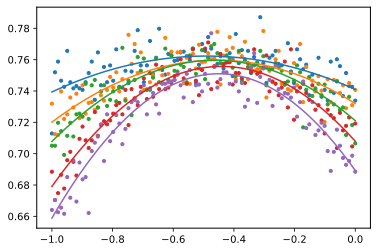

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

avg = 0
beta_swept = np.linspace(-1.0, 0, 100)
for j in range(len(reps)):
    param, fit, pcov = ut.fit_function(beta_swept, pop2_exp[j], 
                                    lambda x, A, B, x0: (A*(x-x0)**2+B),
                                    [1, 0.01, -0.5])
    plt.plot(beta_swept, fit)
    plt.scatter(beta_swept, pop2_exp[j], s=10)
    avg+=param[2]
    print(f'{param[2]}')

avg/5

In [18]:
ran_job = None
for ran_job in provider.backend.jobs():
    print(str(ran_job.job_id()) + " " + str(ran_job.status()))

ctnjd8x6g3rg0087enkg JobStatus.DONE
ctnj5w7sj17g008229zg JobStatus.ERROR
ctngked4gjh0008phjfg JobStatus.DONE
ctngh7wsj17g00821z70 JobStatus.DONE
ctn06jj4gzyg008ze6xg JobStatus.DONE
ctn06j26g3rg0087ccf0 JobStatus.DONE
ctmzk2c4gzyg008ze510 JobStatus.DONE
ctmzk1m907y0008w8e80 JobStatus.DONE
ctmvb8xx7b5g0080e29g JobStatus.DONE
ctmvb8d907y0008w78gg JobStatus.DONE
